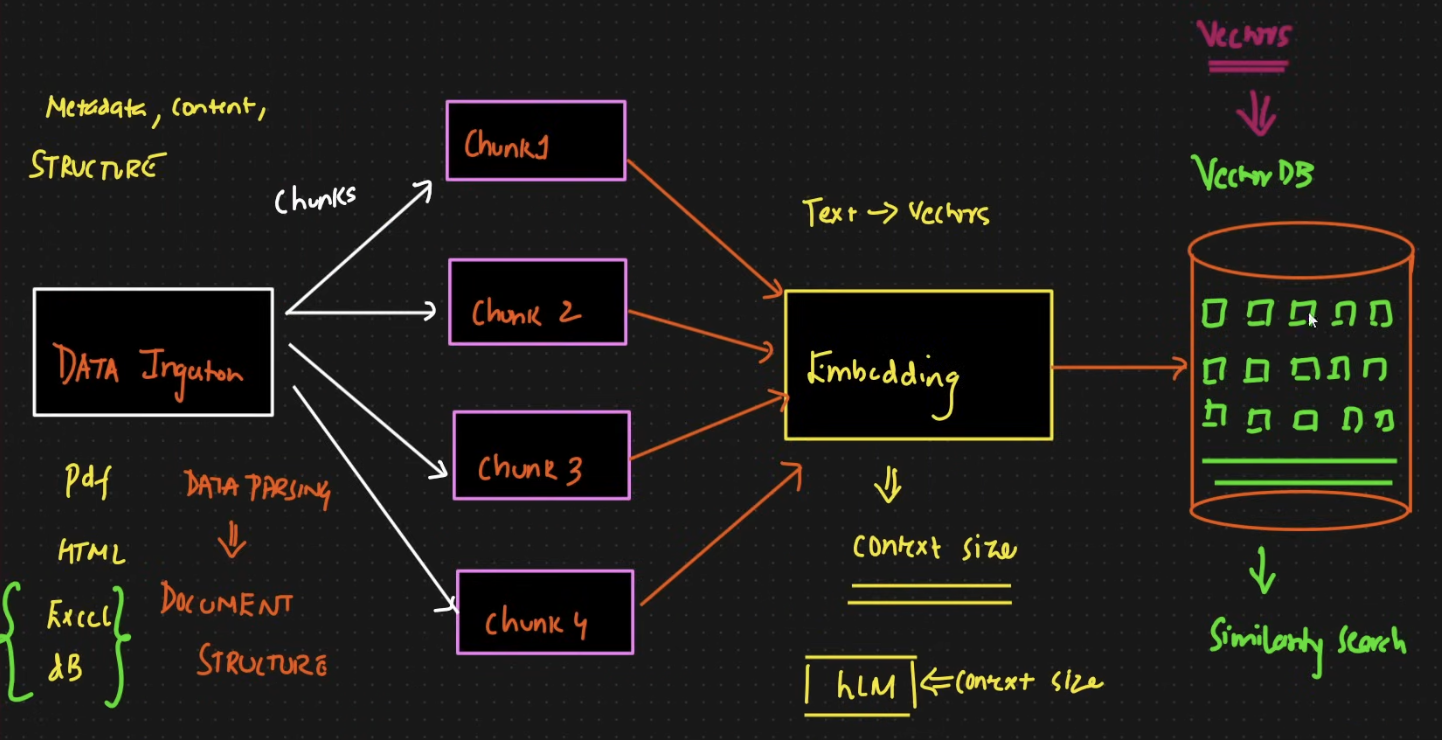

In [1]:
import os
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pathlib import Path

In [8]:
# loader = PyPDFLoader(str("../data/pdf_files/2020.coling-tutorials.2.pdf"))
# loader

In [9]:
# Read all the pdf's in the data/pdf_files directory
def load_pdfs_from_directory(directory: str):
    all_documents = []
    pdf_dir = Path(directory)

    # Find all PDF files recursively
    pdf_files = list(pdf_dir.rglob("**/*.pdf"))

    print(f"Found {len(pdf_files)} PDF files to lorad and process.")

    for pdf_file in pdf_files:
        print(f"\nProcessing file: {pdf_file.name}")

        try:
            loader = PyPDFLoader(str(pdf_file))
            print(f"PyPDFLoader initialized : {loader}")
            documents = loader.load()

            # Add source information to metadata
            for doc in documents:
                doc.metadata["source_file"] = str(pdf_file.name)
                doc.metadata["file_type"] = "pdf"

            all_documents.extend(documents)
            print(f"    ✔️ Loaded {len(documents)} pages")
        except Exception as e:
            print(f"    ❌ Error loading {pdf_file.name}: {e}")

    print(f"\nTotal documents loaded: {len(all_documents)}")
    return all_documents

In [10]:
# Process all PDFs in the specified directory
all_pdf_documents = load_pdfs_from_directory("../data")

Found 3 PDF files to lorad and process.

Processing file: NIPS-2017-attention-is-all-you-need-Paper.pdf
PyPDFLoader initialized : <langchain_community.document_loaders.pdf.PyPDFLoader object at 0x109da2350>
    ✔️ Loaded 11 pages

Processing file: book_embNLP_draft.pdf
PyPDFLoader initialized : <langchain_community.document_loaders.pdf.PyPDFLoader object at 0x109da1e50>
    ✔️ Loaded 163 pages

Processing file: 2020.coling-tutorials.2.pdf
PyPDFLoader initialized : <langchain_community.document_loaders.pdf.PyPDFLoader object at 0x10a40b230>
    ✔️ Loaded 6 pages

Total documents loaded: 180


In [11]:
all_pdf_documents[0]

Document(metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-German translation, improving over the existing best ensemble result by over 1 BLEU. On E

# Text splitting into Chunks

In [16]:
def split_documents(documents, chunk_size=1000, chunk_overlap=200):
    """Split documents into smaller chunks for better RAG performance."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    split_docs = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} paged document into {len(split_docs)} chunks.")

    return split_docs

In [17]:
split_docs = split_documents(all_pdf_documents)

if split_docs:
    print("\nSample chunk:")
    print(f"Content: {split_docs[0].page_content[:50]}...")
    print(f"Metadata: {split_docs[0].metadata}")

Split 180 paged document into 572 chunks.

Sample chunk:
Content: Attention Is All You Need
Ashish Vaswani∗
Google B...
Metadata: {'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 

# Data Embedding and Vector Store

In [18]:
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import uuid
from typing import List, Dict, Any, Tuple
from sklearn.metrics.pairwise import cosine_similarity

/Users/tripathimachine/Desktop/Apps/GitHub_Repo/LLM-RAG-AgenticAI/.llm_rag_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class EmbeddingManager:
    """Handdles document embedding generation using SentenceTransformers and stores them in ChromaDB."""

    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model_name = model_name
        self.model = None
        self._load_model()

    def _load_model(self):
        """Load the SentenceTransformer model."""
        try:
            print(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name)
            print("Model loaded successfully. Embedding dimension: {self.model.get_sentence_embedding_dimension()}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings for a list of texts."""
        if not self.model:
            raise ValueError("Model not loaded.")
        
        print(f"Generating Embedding for {len(texts)} texts...")
        embeddings = self.model.encode(texts, show_progress_bar=True)
        print(f"Generated embeddings with shape: {embeddings.shape}")
        return embeddings
    

    def get_embedding_dimension(self) -> int:
        """Get the dimension of the embeddings."""
        if not self.model:
            raise ValueError("Model not loaded.")
        return self.model.get_sentence_embedding_dimension()
    

In [20]:
# Initialize the Embedding Manager
embedding_manager = EmbeddingManager()

embedding_manager

Loading embedding model: all-MiniLM-L6-v2
Model loaded successfully. Embedding dimension: {self.model.get_sentence_embedding_dimension()}


In [21]:
# Vector Store with ChromaDB
class VectorStore:
    """
    Manages document embeddings in a ChromaDB vector store
    """

    def __init__(self, collection_name: str = "documents", persist_directory: str = "./chroma_db"):
        self.collection_name = collection_name
        self.persist_directory = persist_directory
        self.client = None
        self.collection = None
        self._initialize_store()

    def _initialize_store(self):
        """Initialize ChromaDB client and collection."""
        try:
            print("Initializing ChromaDB client...")
            # Create persistent ChromaDB client
            os.makedirs(self.persist_directory, exist_ok=True)
            self.client = chromadb.PersistentClient(path = self.persist_directory)

            # Get or Create Collection
            self.collection = self.client.get_or_create_collection(
                name=self.collection_name,
                metadata={"description": "PDF Document embeddings collection for RAG Application"}
            )

            print(f"Vector Store initializing, Colelction: {self.collection_name}")
            print(f"Existing documents in collection: {self.collection.count()}")

        except Exception as e:
            print(f"Error initializing ChromaDB: {e}")
            raise


    def add_documents(self, documents: List[Any], embeddings: np.ndarray):
        """Add documents and their embeddings to the collection in Vector Store."""
        if len(documents) != len(embeddings):
            raise ValueError("Number of documents and embeddings must match.")
        
        print(f"Adding {len(documents)} documents to vector store ...")

        # Prepare data for ChromaDB
        ids = []
        metadatas = []
        documents_text = []
        embeddings_list = []

        for i, (doc, emb) in enumerate(zip(documents, embeddings)):
            doc_id = f"doc_{uuid.uuid4().hex[:8]}_{i}"
            ids.append(doc_id)

            # Prepare metadata
            metadata = dict(doc.metadata)
            metadata["doc_index"] = i   
            metadata['content_length'] = len(doc.page_content)
            metadatas.append(metadata)

            # Document Content
            documents_text.append(doc.page_content)

            # Embedding
            embeddings_list.append(emb.tolist())

            # Add to Collection
            try:
                self.collection.add(
                    ids=ids,
                    metadatas=metadatas,
                    documents=documents_text,
                    embeddings=embeddings_list
                )
                print(f"Successfully added {len(documents)} documents to vector store.")
                print(f"Total Documents in collection: {self.collection.count()}")
            except Exception as e:
                print(f"Error adding documents to vector store: {e}")
                raise               
             

In [22]:
vector_store=VectorStore()
vector_store

Initializing ChromaDB client...
Vector Store initializing, Colelction: documents
Existing documents in collection: 0


# Convert text to embeddings

In [23]:
texts = [doc.page_content for doc in split_docs]

# Generate embeddings
embeddings = embedding_manager.generate_embeddings(texts)

# Store into Vector Store
vector_store.add_documents(split_docs, embeddings)

Generating Embedding for 572 texts...


Batches: 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]


Adding 572 documents to vector store ...
Successfully added 572 documents to vector store.
Total Documents in collection: 1
Successfully added 572 documents to vector store.
Total Documents in collection: 2
Successfully added 572 documents to vector store.
Total Documents in collection: 3
Successfully added 572 documents to vector store.
Total Documents in collection: 4
Successfully added 572 documents to vector store.
Total Documents in collection: 5
Successfully added 572 documents to vector store.
Total Documents in collection: 6
Successfully added 572 documents to vector store.
Total Documents in collection: 7
Successfully added 572 documents to vector store.
Total Documents in collection: 8
Successfully added 572 documents to vector store.
Total Documents in collection: 9
Successfully added 572 documents to vector store.
Total Documents in collection: 10
Successfully added 572 documents to vector store.
Total Documents in collection: 11
Successfully added 572 documents to vector s

# Retriever Pipeline From VectorStore

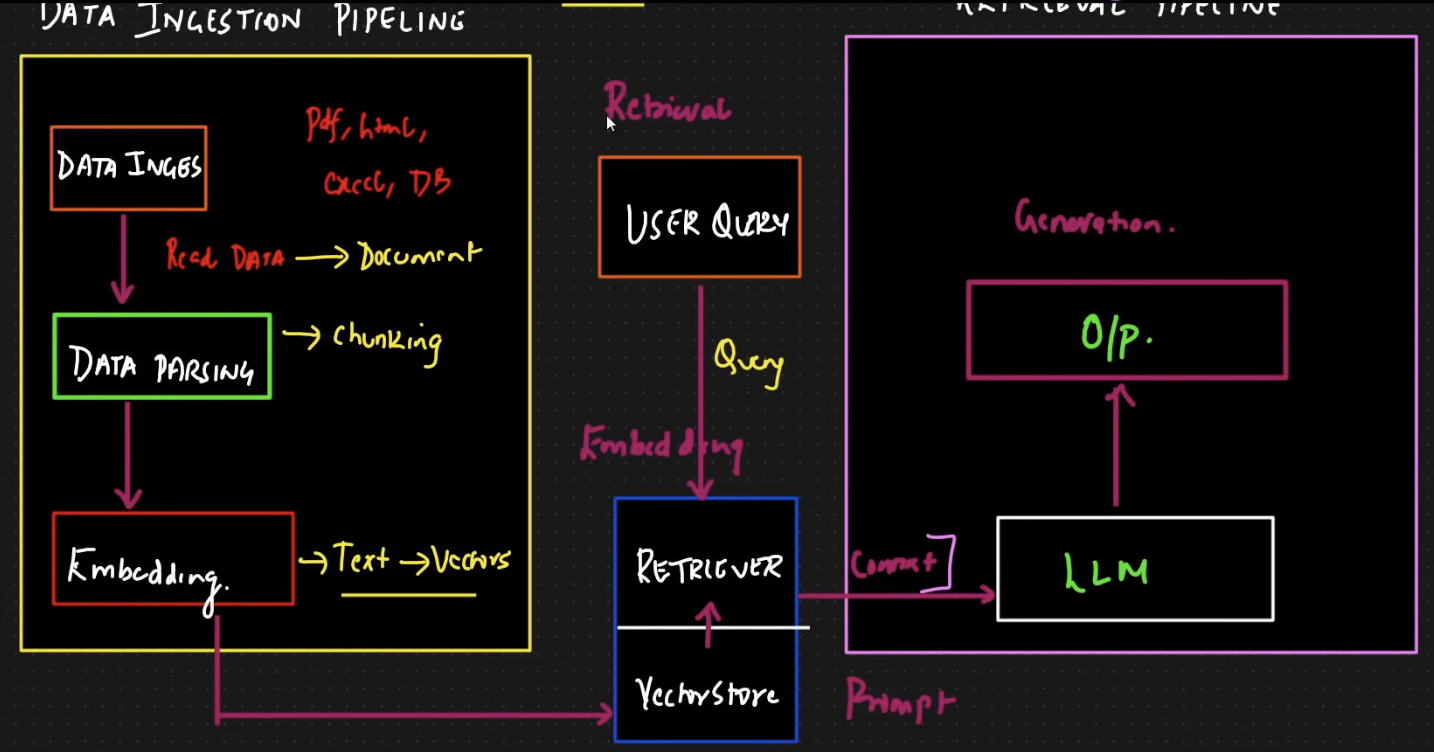

In [25]:
class RAGRetriever:
    """Handles query-based retrieval from the vector store."""

    def __init__(self, vector_store: VectorStore, embedding_manager: EmbeddingManager):
        """Initialize the retriever"""
        self.vector_store = vector_store
        self.embedding_manager = embedding_manager

    def retrieve(self, query: str, top_k: int = 5, score_threshold: float = 0.0) -> List[Dict[str, Any]]:
        """Retrieve Relevant Documents from a query."""
        print(f"Retrieving documents for query: {query}")
        print(f"Top K: {top_k}, Score Threshold: {score_threshold}")

        # Generate Query Embedding
        query_embedding = self.embedding_manager.generate_embeddings([query])[0]

        # Search in Vector Store
        try:
            results = self.vector_store.collection.query(
                query_embeddings = [query_embedding.tolist()],
                n_results = top_k,
            )

            # Process results
            retrieved_docs = []

            if results['documents'] and results['documents'][0]:
                documents = results['documents'][0]
                metadatas = results['metadatas'][0]
                distances = results['distances'][0]
                ids = results['ids'][0]

                for i, (doc_id, document, metadata, distance) in enumerate(zip(ids, documents, metadatas, distances)):
                    # Convert distance to similarity score (ChromaDB uses Cosine distance)
                    similarity_score = 1 - distance

                    if similarity_score >= score_threshold:
                        retrieved_docs.append({
                            "id": doc_id,
                            "content": document,
                            "metadata": metadata,
                            "similarity_score": similarity_score,
                            "distance": distance,
                            "rank": i + 1
                        })

                print(f"Retrieved {len(retrieved_docs)} documents after applying score threshold.")
            else:
                print("No documents found for the given query.")
            
            return retrieved_docs
        except Exception as e:
            print(f"Error during retrieval: {e}")
            return []

In [26]:
rag_retriever = RAGRetriever(vector_store, embedding_manager)

In [27]:
rag_retriever

In [29]:
# rag_retriever.retrieve("What is attention is all you need")

rag_retriever.retrieve("What is Natural Language Processing")

Retrieving documents for query: What is Natural Language Processing
Top K: 5, Score Threshold: 0.0
Generating Embedding for 1 texts...


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

Retrieved 5 documents after applying score threshold.


[{'id': 'doc_7f100323_89',
  'content': 'DRAFT\n10\nC H A P T E R 2\nBackground\n2.1 NATURAL LANGUAGE PROCESSING\nFUNDAMENTALS\nNatural Language Processing (NLP) lies at the intersection of linguistics and computer\nscience. In this section we cover some fundamental topics in linguistics and NLP\nwhich will be recurrent in most of the chapters. While the coverage of these topics\nwill be quite shallow, this will give the reader a basic understanding which should be\nenough to follow the rest of the book.\n2.1.1 LINGUISTIC FUNDAMENTALS\nLinguistics, as an area of study, comprises many subfields; for instance, phonetics,\nphonology, lexicography, psycholinguistics, and discourse. While in this book we\nwill not cover these topics in-depth, we would recommendBender [2013], a book\nfrom this editorial, which covers the most important aspects of linguistics directly\nrelated to natural language processing. In the following, we provide a brief overview\nof three major fields of study in ling